<a href="https://colab.research.google.com/github/acse-2020/acse2020-acse9-finalreport-acse-jaq15/blob/main/notebooks/CNN_LSTM/CNN_LSTM_Google.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Imports

The cells below handle all the necessary imports to run our models, making use of the public repo feeder_repo, linked <!-- [Text](link) -->
[here](https://github.com/acse-jaq15/feeder_repo).

In [1]:
# clone the feeder repo to get data_reader module and financial time series data
!git clone https://github.com/acse-jaq15/feeder_repo.git

Cloning into 'feeder_repo'...
remote: Enumerating objects: 150, done.
remote: Counting objects: 100% (150/150), done.
remote: Compressing objects: 100% (145/145), done.
remote: Total 150 (delta 73), reused 6 (delta 2), pack-reused 0
Receiving objects: 100% (150/150), 121.14 KiB | 780.00 KiB/s, done.
Resolving deltas: 100% (73/73), done.


In [2]:
# using '%' to enforce a permanent change of directory
%cd feeder_repo/

/content/feeder_repo


In [3]:
# checking contents listed correctly, should read:
# baseline_model.py data data_reader.py LICENSE README.md security_plotter.py
!ls

base_model.py  data  data_reader.py  LICENSE  README.md  security_plotter.py


In [4]:
import math
import sys
import keras
import os
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import GRU
from keras.layers import Dropout
from keras.layers import *
from keras.utils.layer_utils import count_params
from keras.utils.vis_utils import plot_model
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split
from keras.callbacks import EarlyStopping, Callback
from keras.optimizers import RMSprop, SGD, Adam, Nadam
from keras.initializers import random_normal

In [5]:
# appending path with 'feeder_repo' string
sys.path.append('feeder_repo')

# import Data_Reader class from data_reader module
from feeder_repo.data_reader import Data_Reader
# import Baseline_Model class from base_model module
from feeder_repo.base_model import Base_Model
# import Security_Plotter class from security_plotter module
from feeder_repo.security_plotter import Security_Plotter

In [6]:
# checking if the notebook is running on a GPU
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
    print('Select the Runtime > "Change runtime type" menu to enable a GPU accelerator, ')
    print('and then re-execute this cell.')
else:
    print(gpu_info)

Wed Jul 21 16:18:05 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.42.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   39C    P0    30W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# Handling the data
Here the Data_Reader class is used to read the time series data and extract training, test and validation sets, along with the relevant X and y values.

In [7]:
# storing the file to be read as a string
in_str = 'Google'
# storing the year of the time series to be used as test data
in_yr = 2019
# creating a variable to store the model name
model_str = 'CNN_LSTM'
# setting our window_length to be 30 days
window_len = 30

In [8]:
# creating an instance of Data_Reader class
in_data = Data_Reader(in_str, in_yr)
# calling class method extract_train_test to generate training and test datasets
in_data.extract_train_test()
# calling class method extract_xy to generate X and y training and test datasets
in_data.extract_xy(window_len, time_distributed=True)

# assigning X_train and y_train
X_train = in_data.X_train
y_train = in_data.y_train

# assigning X_test and y_test
X_test = in_data.X_test
y_test = in_data.y_test

# assigning X_val_train and y_val_train
X_val_train = in_data.X_val_train
y_val_train = in_data.y_val_train

# assigning X_val_test and y_val_test
X_val_test = in_data.X_val_test
y_val_test = in_data.y_val_test

# Setting up wandb itegration
Here wandb is used to perform hyperparameter tuning.

In [9]:
# installing the wandb library and importing
%pip install wandb -q
import wandb
from wandb.keras import WandbCallback

     |████████████████████████████████| 1.8 MB 15.4 MB/s 
     |████████████████████████████████| 170 kB 55.4 MB/s 
     |████████████████████████████████| 133 kB 70.0 MB/s 
     |████████████████████████████████| 97 kB 8.9 MB/s 
     |████████████████████████████████| 138 kB 57.5 MB/s 
     |████████████████████████████████| 63 kB 2.2 MB/s 
     |████████████████████████████████| 62 kB 992 kB/s 
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires requests~=2.23.0, but you have requests 2.26.0 which is incompatible.
datascience 0.10.6 requires folium==0.2.1, but you have folium 0.8.3 which is incompatible.


In [10]:
!pip install wandb -qq

In [11]:
# logging in so the hyperparameter tunings sweeps can be saved
!wandb login

wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter: 
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


In [12]:
# configuring the sweep, making use of a random search methodology
sweep_config = {
    'method': 'random', #grid, random
    'metric': {
      'name': 'mse',
      'goal': 'minimize'   
    },
    'parameters': {
        'epochs': {
            'values': [50, 100, 200]
        },
        'batch_size': {
            'values': [128, 64, 32]
        },
        'learning_rate': {
            'values': [0.005, 0.001, 0.0005]
        },
        'optimizer': {
            'values': ['adam', 'nadam', 'rmsprop', 'sgd']
        },
        'activation': {
            'values': ['relu', 'selu']
        }
    }
}

In [13]:
# wandb calls this training function to run through the hyperparameter search
def train():
    # default values for searching
    config_defaults = {
        'epochs': 100,
        'batch_size': 32,
        'learning_rate': 0.005,
        'optimizer': 'adam',
        'activation': 'tanh',
        'momentum': 0.9,
        'seed': 42
    }

    # Initialize a new wandb run
    wandb.init(config=config_defaults)
    
    # Config is a variable that holds and saves hyperparameters and inputs
    config = wandb.config

    # setting keras model to sequential mode
    model = Sequential()

    # layer 1
    model.add(TimeDistributed(Conv1D(filters=128, kernel_size=2, activation=config.activation), input_shape=(None, window_len, 1)))
    # layer 2
    model.add(TimeDistributed(MaxPooling1D(pool_size=2)))
    # layer 3
    model.add(TimeDistributed(Flatten()))
    # layer 4
    model.add(LSTM(units=128, activation='tanh', return_sequences=False))
    # layer 5
    model.add(Dropout(0.1))
    # layer 6
    model.add(Dense(1))

    # Define the optimizer
    if config.optimizer=='sgd':
      optimizer = SGD(learning_rate=config.learning_rate, decay=1e-5, momentum=config.momentum, nesterov=True)
    elif config.optimizer=='rmsprop':
      optimizer = RMSprop(learning_rate=config.learning_rate, decay=1e-5)
    elif config.optimizer=='adam':
      optimizer = Adam(learning_rate=config.learning_rate, beta_1=0.9, beta_2=0.999, clipnorm=1.0)
    elif config.optimizer=='nadam':
      optimizer = Nadam(learning_rate=config.learning_rate, beta_1=0.9, beta_2=0.999, clipnorm=1.0)

    model.compile(loss = "mean_squared_error", optimizer=optimizer, metrics=['mean_squared_error', 'mean_absolute_error'])

    model.fit(X_val_train, y_val_train, batch_size=config.batch_size,
              epochs=config.epochs,
              validation_data=(X_val_test, y_val_test),
              callbacks=[WandbCallback(validation_data=(X_val_test, y_val_test)),
                          EarlyStopping(patience=10, restore_best_weights=True)])

In [14]:
# setting up our sweep_id
sweep_id = wandb.sweep(sweep_config, project='ACSE_9_'+model_str)

Create sweep with ID: bpufmj8y
Sweep URL: https://wandb.ai/acse-jaq15/ACSE_9_CNN_LSTM/sweeps/bpufmj8y


In [16]:
# initialising a new sweep
wandb.agent(sweep_id, train, project='ACSE_9_'+model_str)

wandb: Agent Starting Run: zy2xc37u with config:
wandb: 	activation: relu
wandb: 	batch_size: 32
wandb: 	epochs: 200
wandb: 	learning_rate: 0.0005
wandb: 	optimizer: sgd


Epoch 1/200
31/31 [==============================] - 3s 32ms/step - loss: 0.2073 - mean_squared_error: 0.2073 - mean_absolute_error: 0.3688 - val_loss: 0.1572 - val_mean_squared_error: 0.1572 - val_mean_absolute_error: 0.3268
Epoch 2/200
31/31 [==============================] - 0s 5ms/step - loss: 0.1140 - mean_squared_error: 0.1140 - mean_absolute_error: 0.2621 - val_loss: 0.0841 - val_mean_squared_error: 0.0841 - val_mean_absolute_error: 0.2279
Epoch 3/200
31/31 [==============================] - 0s 6ms/step - loss: 0.0663 - mean_squared_error: 0.0663 - mean_absolute_error: 0.2083 - val_loss: 0.0564 - val_mean_squared_error: 0.0564 - val_mean_absolute_error: 0.1884
Epoch 4/200
31/31 [==============================] - 0s 5ms/step - loss: 0.0488 - mean_squared_error: 0.0488 - mean_absolute_error: 0.1854 - val_loss: 0.0453 - val_mean_squared_error: 0.0453 - val_mean_absolute_error: 0.1728
Epoch 5/200
31/31 [==============================] - 0s 5ms/step - loss: 0.0384 - mean_squared_erro

wandb: Agent Starting Run: r77x0d9f with config:
wandb: 	activation: selu
wandb: 	batch_size: 128
wandb: 	epochs: 200
wandb: 	learning_rate: 0.0005
wandb: 	optimizer: sgd


Epoch 1/200
8/8 [==============================] - 3s 123ms/step - loss: 0.1848 - mean_squared_error: 0.1848 - mean_absolute_error: 0.3542 - val_loss: 0.1931 - val_mean_squared_error: 0.1931 - val_mean_absolute_error: 0.3811
Epoch 2/200
8/8 [==============================] - 0s 7ms/step - loss: 0.1597 - mean_squared_error: 0.1597 - mean_absolute_error: 0.3213 - val_loss: 0.1416 - val_mean_squared_error: 0.1416 - val_mean_absolute_error: 0.3161
Epoch 3/200
8/8 [==============================] - 0s 7ms/step - loss: 0.1044 - mean_squared_error: 0.1044 - mean_absolute_error: 0.2496 - val_loss: 0.0985 - val_mean_squared_error: 0.0985 - val_mean_absolute_error: 0.2546
Epoch 4/200
8/8 [==============================] - 0s 8ms/step - loss: 0.0698 - mean_squared_error: 0.0698 - mean_absolute_error: 0.2023 - val_loss: 0.0682 - val_mean_squared_error: 0.0682 - val_mean_absolute_error: 0.2079
Epoch 5/200
8/8 [==============================] - 0s 9ms/step - loss: 0.0505 - mean_squared_error: 0.0505

wandb: Agent Starting Run: 9v4c9a6f with config:
wandb: 	activation: relu
wandb: 	batch_size: 128
wandb: 	epochs: 200
wandb: 	learning_rate: 0.005
wandb: 	optimizer: adam


Epoch 1/200
8/8 [==============================] - 4s 124ms/step - loss: 0.0978 - mean_squared_error: 0.0978 - mean_absolute_error: 0.2277 - val_loss: 0.0323 - val_mean_squared_error: 0.0323 - val_mean_absolute_error: 0.1484
Epoch 2/200
8/8 [==============================] - 0s 8ms/step - loss: 0.0130 - mean_squared_error: 0.0130 - mean_absolute_error: 0.0814 - val_loss: 0.0343 - val_mean_squared_error: 0.0343 - val_mean_absolute_error: 0.1502
Epoch 3/200
8/8 [==============================] - 0s 7ms/step - loss: 0.0047 - mean_squared_error: 0.0047 - mean_absolute_error: 0.0523 - val_loss: 0.0276 - val_mean_squared_error: 0.0276 - val_mean_absolute_error: 0.1361
Epoch 4/200
8/8 [==============================] - 0s 7ms/step - loss: 0.0042 - mean_squared_error: 0.0042 - mean_absolute_error: 0.0526 - val_loss: 0.0257 - val_mean_squared_error: 0.0257 - val_mean_absolute_error: 0.1324
Epoch 5/200
8/8 [==============================] - 0s 10ms/step - loss: 0.0034 - mean_squared_error: 0.003

wandb: Agent Starting Run: 6jradwxc with config:
wandb: 	activation: relu
wandb: 	batch_size: 32
wandb: 	epochs: 50
wandb: 	learning_rate: 0.0005
wandb: 	optimizer: nadam


Epoch 1/50
31/31 [==============================] - 4s 35ms/step - loss: 0.0722 - mean_squared_error: 0.0722 - mean_absolute_error: 0.1760 - val_loss: 0.0262 - val_mean_squared_error: 0.0262 - val_mean_absolute_error: 0.1346
Epoch 2/50
31/31 [==============================] - 0s 9ms/step - loss: 0.0028 - mean_squared_error: 0.0028 - mean_absolute_error: 0.0397 - val_loss: 0.0228 - val_mean_squared_error: 0.0228 - val_mean_absolute_error: 0.1257
Epoch 3/50
31/31 [==============================] - 0s 9ms/step - loss: 0.0022 - mean_squared_error: 0.0022 - mean_absolute_error: 0.0356 - val_loss: 0.0225 - val_mean_squared_error: 0.0225 - val_mean_absolute_error: 0.1238
Epoch 4/50
31/31 [==============================] - 0s 7ms/step - loss: 0.0021 - mean_squared_error: 0.0021 - mean_absolute_error: 0.0342 - val_loss: 0.0187 - val_mean_squared_error: 0.0187 - val_mean_absolute_error: 0.1127
Epoch 5/50
31/31 [==============================] - 0s 7ms/step - loss: 0.0018 - mean_squared_error: 0.

wandb: Agent Starting Run: okh5qnb6 with config:
wandb: 	activation: selu
wandb: 	batch_size: 64
wandb: 	epochs: 100
wandb: 	learning_rate: 0.0005
wandb: 	optimizer: rmsprop


Epoch 1/100
16/16 [==============================] - 3s 60ms/step - loss: 0.0416 - mean_squared_error: 0.0416 - mean_absolute_error: 0.1271 - val_loss: 0.0465 - val_mean_squared_error: 0.0465 - val_mean_absolute_error: 0.1736
Epoch 2/100
16/16 [==============================] - 0s 7ms/step - loss: 0.0101 - mean_squared_error: 0.0101 - mean_absolute_error: 0.0783 - val_loss: 0.0415 - val_mean_squared_error: 0.0415 - val_mean_absolute_error: 0.1638
Epoch 3/100
16/16 [==============================] - 0s 7ms/step - loss: 0.0106 - mean_squared_error: 0.0106 - mean_absolute_error: 0.0775 - val_loss: 0.0470 - val_mean_squared_error: 0.0470 - val_mean_absolute_error: 0.1751
Epoch 4/100
16/16 [==============================] - 0s 6ms/step - loss: 0.0081 - mean_squared_error: 0.0081 - mean_absolute_error: 0.0656 - val_loss: 0.0208 - val_mean_squared_error: 0.0208 - val_mean_absolute_error: 0.1192
Epoch 5/100
16/16 [==============================] - 0s 7ms/step - loss: 0.0045 - mean_squared_erro

wandb: Agent Starting Run: oidxhcuj with config:
wandb: 	activation: relu
wandb: 	batch_size: 128
wandb: 	epochs: 100
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nadam


Epoch 1/100
8/8 [==============================] - 3s 118ms/step - loss: 0.1046 - mean_squared_error: 0.1046 - mean_absolute_error: 0.2269 - val_loss: 0.0303 - val_mean_squared_error: 0.0303 - val_mean_absolute_error: 0.1443
Epoch 2/100
8/8 [==============================] - 0s 10ms/step - loss: 0.0031 - mean_squared_error: 0.0031 - mean_absolute_error: 0.0430 - val_loss: 0.0266 - val_mean_squared_error: 0.0266 - val_mean_absolute_error: 0.1350
Epoch 3/100
8/8 [==============================] - 0s 14ms/step - loss: 0.0024 - mean_squared_error: 0.0024 - mean_absolute_error: 0.0377 - val_loss: 0.0264 - val_mean_squared_error: 0.0264 - val_mean_absolute_error: 0.1342
Epoch 4/100
8/8 [==============================] - 0s 11ms/step - loss: 0.0024 - mean_squared_error: 0.0024 - mean_absolute_error: 0.0372 - val_loss: 0.0262 - val_mean_squared_error: 0.0262 - val_mean_absolute_error: 0.1335
Epoch 5/100
8/8 [==============================] - 0s 10ms/step - loss: 0.0024 - mean_squared_error: 0.

wandb: Agent Starting Run: iq9xkklv with config:
wandb: 	activation: relu
wandb: 	batch_size: 128
wandb: 	epochs: 100
wandb: 	learning_rate: 0.0005
wandb: 	optimizer: sgd


Epoch 1/100
8/8 [==============================] - 3s 126ms/step - loss: 0.2020 - mean_squared_error: 0.2020 - mean_absolute_error: 0.3687 - val_loss: 0.2197 - val_mean_squared_error: 0.2197 - val_mean_absolute_error: 0.4107
Epoch 2/100
8/8 [==============================] - 0s 10ms/step - loss: 0.1877 - mean_squared_error: 0.1877 - mean_absolute_error: 0.3516 - val_loss: 0.1877 - val_mean_squared_error: 0.1877 - val_mean_absolute_error: 0.3728
Epoch 3/100
8/8 [==============================] - 0s 11ms/step - loss: 0.1526 - mean_squared_error: 0.1526 - mean_absolute_error: 0.3066 - val_loss: 0.1561 - val_mean_squared_error: 0.1561 - val_mean_absolute_error: 0.3322
Epoch 4/100
8/8 [==============================] - 0s 8ms/step - loss: 0.1244 - mean_squared_error: 0.1244 - mean_absolute_error: 0.2723 - val_loss: 0.1290 - val_mean_squared_error: 0.1290 - val_mean_absolute_error: 0.2944
Epoch 5/100
8/8 [==============================] - 0s 9ms/step - loss: 0.1070 - mean_squared_error: 0.10

wandb: Ctrl + C detected. Stopping sweep.


# Setting up the best model
Using the best values from the hyperparamter search with wandb, the most optimal model configuration is used.

In [17]:
# picking the best values
best_config = {
    'epochs': 100,
    'batch_size': 32,
    'learning_rate': 0.001,
    'optimizer': 'adam',
    'activation': 'selu'
}

In [18]:
# clearing the settings on the keras backend
keras.backend.clear_session()

# setting keras model to sequential mode
model = Sequential()

# layer 1
model.add(TimeDistributed(Conv1D(filters=128, kernel_size=2, activation=best_config['activation']), input_shape=(None, window_len, 1)))
# layer 2
model.add(TimeDistributed(MaxPooling1D(pool_size=2)))
# layer 3
model.add(TimeDistributed(Flatten()))
# layer 4
model.add(LSTM(units=128, activation='tanh', return_sequences=False))
# layer 5
model.add(Dropout(0.1))
# layer 6
model.add(Dense(1))

# defining the optimiser
if best_config['optimizer'] == 'sgd':
  optimizer = SGD(learning_rate=best_config['learning_rate'], decay=1e-5, momentum=0.9, nesterov=True)
elif best_config['optimizer'] == 'rmsprop':
  optimizer = RMSprop(learning_rate=best_config['learning_rate'], decay=1e-5)
elif best_config['optimizer'] == 'adam':
  optimizer = Adam(learning_rate=best_config['learning_rate'], beta_1=0.9, beta_2=0.999, clipnorm=1.0)
elif best_config['optimizer'] == 'nadam':
  optimizer = Nadam(learning_rate=best_config['learning_rate'], beta_1=0.9, beta_2=0.999, clipnorm=1.0)

# compile the model
model.compile(optimizer, loss='mean_squared_error')

# counting the number of trainable parameters
trainable_count = count_params(model.trainable_weights)
print('Total number of trainable parameters: ', trainable_count)

Total number of trainable parameters:  984065


In [19]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed (TimeDistri (None, None, 29, 128)     384       
_________________________________________________________________
time_distributed_1 (TimeDist (None, None, 14, 128)     0         
_________________________________________________________________
time_distributed_2 (TimeDist (None, None, 1792)        0         
_________________________________________________________________
lstm (LSTM)                  (None, 128)               983552    
_________________________________________________________________
dropout (Dropout)            (None, 128)               0         
_________________________________________________________________
dense (Dense)                (None, 1)                 129       
Total params: 984,065
Trainable params: 984,065
Non-trainable params: 0
__________________________________________________

In [20]:
# fitting the model to the training dataset
model.fit(X_train, y_train, epochs=best_config['epochs'], batch_size=best_config['batch_size'])

Epoch 1/100
39/39 [==============================] - 2s 4ms/step - loss: 0.0436
Epoch 2/100
39/39 [==============================] - 0s 4ms/step - loss: 0.0035
Epoch 3/100
39/39 [==============================] - 0s 4ms/step - loss: 0.0022
Epoch 4/100
39/39 [==============================] - 0s 3ms/step - loss: 0.0022
Epoch 5/100
39/39 [==============================] - 0s 4ms/step - loss: 0.0019
Epoch 6/100
39/39 [==============================] - 0s 4ms/step - loss: 0.0017
Epoch 7/100
39/39 [==============================] - 0s 4ms/step - loss: 0.0014
Epoch 8/100
39/39 [==============================] - 0s 4ms/step - loss: 0.0016
Epoch 9/100
39/39 [==============================] - 0s 4ms/step - loss: 0.0015
Epoch 10/100
39/39 [==============================] - 0s 4ms/step - loss: 0.0013
Epoch 11/100
39/39 [==============================] - 0s 4ms/step - loss: 0.0012
Epoch 12/100
39/39 [==============================] - 0s 4ms/step - loss: 0.0012
Epoch 13/100
39/39 [=================

In [21]:
# creating an instance of Baseline_Model class using X_test
base_model = Base_Model(X_test, window_len)
# calling predict_y method
base_model.predict_y(in_data.test_len - window_len)

# using the model to predict y from X_test
y_pred = model.predict(X_test)
# assigning y_dummy variable to .y_pred class attribute
y_dummy = base_model.y_pred

# calling class method extract_real_price to generate unnormalised prices
in_data.extract_real_prices(y_pred, y_dummy)

# assinging y_true variable
y_true = in_data.y_true

# assigning actual_price, predicted_price and dummy_price
actual_price = in_data.actual_price
predicted_price = in_data.predicted_price
dummy_price = in_data.dummy_price

# Plotting the prediction results and getting errors
The cells below plot the actual, predicted and dummy prices using the Security_Plotter class before finally saving the model and plot.

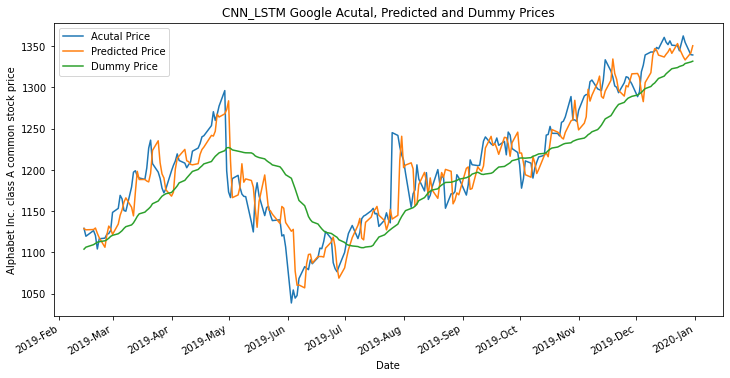

In [22]:
plotter = Security_Plotter(in_data, actual_price, predicted_price,
                            dummy_price, in_data.train_len, window_len, in_str, model_str)

plotter.single_plot()

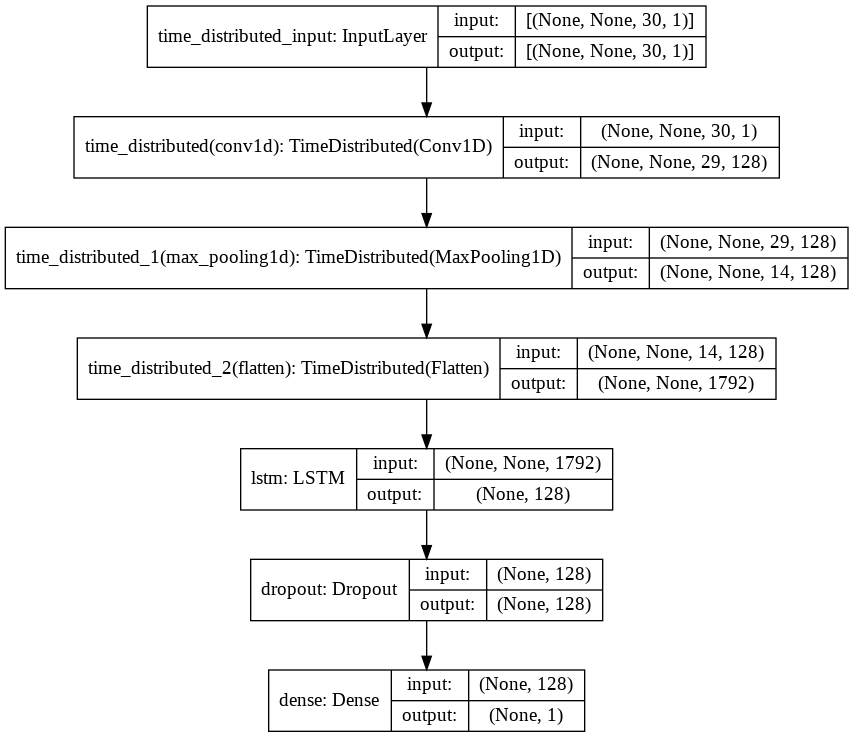

In [23]:
plot_model(model, show_shapes=True, expand_nested=True)

In [24]:
# calculating mean squared error
mse = mean_squared_error(y_true, y_pred)
d_mse = mean_squared_error(y_true, y_dummy)

# calculating root mean squared error
rmse = mean_squared_error(y_true, y_pred, squared=False)
d_rmse = mean_squared_error(y_true, y_dummy, squared=False)

# calculating mean absolute error
mae = mean_absolute_error(y_true, y_pred)
d_mae = mean_absolute_error(y_true, y_dummy)

print('MSE: ', mse)
print('RMSE: ', rmse)
print('MAE: ', mae)
print('Dummy MSE: ', d_mse)
print('Dummy RMSE: ', d_rmse)
print('Dummy MAE: ', d_mae)

MSE:  0.006412647692502546
RMSE:  0.08007900906294074
MAE:  0.058612017054940575
Dummy MSE:  0.01786933010743511
Dummy RMSE:  0.13367621369351806
Dummy MAE:  0.10749275974657799


In [25]:
# creating a string to save the model based on model name
save_path = '/content/gdrive/My Drive/models/'+model_str+'_'+in_str+'/'
# mounting google drive for easy storage of model
from google.colab import drive
# mounting the drive
drive.mount('/content/gdrive/')
# making the relevant directory to store the model
os.mkdir(save_path)
# saving the model
keras.models.save_model(model, save_path)
# saving the model graph
model_graph = plot_model(model, to_file=save_path+model_str+'_'+in_str+'_graph_.png', show_shapes=True, expand_nested=True)
# saving the matplotlib plot
plotter.fig.savefig(save_path+model_str+'_'+in_str+'_plot.png', bbox_inches='tight')
# saving the error metrics as a text file
error_file = open(save_path+model_str+'_'+in_str+'_metrics.txt', 'w+')
error_file.write('MSE: '+str(mse)+'\n'+'RMSE: '+str(rmse)+'\n'+'MAE: '+str(mae)+'\n'+
                 'Dummy MSE: '+str(d_mse)+'\n'+'Dummy RMSE: '+str(d_rmse)+'\n'+'Dummy MAE: '+str(d_mae))
error_file.close()

Mounted at /content/gdrive/


INFO:tensorflow:Assets written to: /content/gdrive/My Drive/models/CNN_LSTM_Google/assets


INFO:tensorflow:Assets written to: /content/gdrive/My Drive/models/CNN_LSTM_Google/assets
